In [1]:
import sys
sys.path.append("../../")

from astronn.datasets import deltascuti, bedding, corot ,starmodels
from astronn import models

import tensorflow as tf
from tensorflow import keras

import numpy as np
import math
import pandas as pd
import shap
from scipy.signal import find_peaks
import pickle

import matplotlib.pyplot as plt

Using TensorFlow backend.


### The next Period-Luminosity relation is obtained by using the data provided in McNamara (2011):

$\log_{10} \text{L}_\odot = 1.4722 (0.100) \log_{10} \text{P} + 2.6089 (0.096)$

&nbsp;
&nbsp;


### Period (variable $\text{P}$) is isolated to obtained its value given the Luminosity.

$\log_{10} \text{L}_\odot - 2.6089 (0.096) = 1.4722 (0.100) \log_{10} \text{P}$

$\log_{10} \text{P} = \Large\frac{\log_{10} \text{L}_\odot - 2.6089 (0.096)}{1.4722 (0.100)}$

$\text{P} = 10\Large^{\Large\frac{\log_{10} \text{L}_\odot - 2.6089 (0.096)}{1.4722 (0.100)}}$

&nbsp;

The fundamental radial mode $\text{P}_0$ is related to the mean density by the pulsation constant $\text{Q} = \text{P} \cdot \Large\sqrt{\frac{\rho}{\rho_\odot}}$ (see Breger, 1990). For $\text{P}_0$ the value of $\text{Q} = [0.03, 0.0492] \text{ (days)}$

Thus, by isolating $\frac{\rho}{\rho_\odot}$ in the above equation and given the value of $\text{P}$, we have a direct estimation of the mean density, as follows:

&nbsp;

$\Large\frac{\rho}{\rho_\odot} = \Big( \frac{Q}{P}\Big)^2$

In [2]:
def get_log_l(P, A=1.4722, e_A=0.1, B=2.6089, e_B=0.096):
    """
    P-L relation for McNamara (2011)
    """
    return A * np.log10(P) + B


def get_P(log_L, A=1.4722, e_A=0.1, B=2.6089, e_B=0.096):
    """
    P variable isolated from log_L relation
    """
    return np.power(10, (log_L - B) / (A))

def get_rho_from_P(P, Q=0.033):
    """
    """
    return np.power(Q/P, 2)

# Example
P = 2.34
log_l = get_log_l(P=P)
P_equation = get_P(log_L=log_l)
print("P value = %f" % P)
print("log L is equal to %f" % log_l)
print("P from equation %f" % P_equation)
# Assert results
np.testing.assert_almost_equal(P, P_equation)

P value = 2.340000
log L is equal to 3.152460
P from equation 2.340000


### Relate to the error, we use a standard error propagation to calculate it:

$\Delta P = \sqrt{\Big(\frac{\delta \text{P}}{\delta \text{A}}\Delta\text{A}\Big)^2  +  \Big(\frac{\delta \text{P}}{\delta \text{B}}\Delta\text{B}\Big)^2   +    \Big(\frac{\delta \text{P}}{\delta \text{L}}\Delta\text{L}\Big)^2}$ where $A = 1.4722$ with uncertainty $\Delta A = 0.100$ and $B = 2.6089$ with uncertainty $\Delta B = 0.096$

$\Delta P = \sqrt{ \Big( 10^{\frac{\text{L}_\odot - B}{A}}  * (2.30258509 * A^2) * \text{L}_\odot * \Delta A \Big)^2 + \Big( 10^{\frac{\text{L}_\odot - B}{A}}  * (2.30258509 * A) *  \Delta B \Big)^2}$


&nbsp;

## Range of $\rho$ used through PL relation

To calculate a valid PL window, we will use the next range:

$\Large[ \frac{\rho}{\rho_\odot}_{\min} = \Big( \frac{0.033}{P+\Delta_p}\Big)^2, \frac{\rho}{\rho_\odot}_{\max} = \Big( \frac{0.042}{P-\Delta_p}\Big)^2 \Large]$

In [3]:
def p_error(log_L, A=1.4722, e_A=0.1, B=2.6089, e_B=0.096):
    """
    """
    return np.sqrt(
        np.power(
            np.power(10, (log_L - B) / A) * (2.30258509 / np.power(A, 2)) * log_L * e_A,
            2,
        )
        + np.power(np.power(10, (log_L - B) / A) * (2.30258509 / A) * e_B, 2)
    )


l_value = 1.3
print(
    "Period for L=%f is equal to %f +-(%f)"
    % (l_value, get_P(log_L=1.3), p_error(log_L=1.3))
)

Period for L=1.300000 is equal to 0.129099 +-(0.026337)


### Relation Rodriguez-Martin et.al. 2020

$\frac{\bar{\rho}}{\rho} = 1.6^{+0.5}_{-0.4} \Big( \langle\Delta\nu\rangle / \Delta\nu_\odot \Big)^{2.02^{+0.10}_{-0.10}}$

For the moment, we will use a simetric error in the first term i.e.: $1.6^{+0.5}_{-0.5}$

$\Delta \frac{\bar{\rho}}{\rho} = \sqrt{\Big(\frac{\delta \frac{\bar{\rho}}{\rho}}{\delta \text{A}}\Delta\text{A}\Big)^2  +  \Big(\frac{\delta \frac{\bar{\rho}}{\rho}}{\delta \text{B}}\Delta\text{B}\Big)^2 }$ where $A = 1.6$ with uncertainty $\Delta A = 0.5$ and $B = 2.02$ with uncertainty $\Delta B = 0.1$

$\Delta \frac{\bar{\rho}}{\rho}  = \sqrt{ ( {\langle\Delta\nu\rangle / \Delta\nu_\odot} )^B * \Delta \text{A} )^2 +  (A * ( {\langle\Delta\nu\rangle / \Delta\nu_\odot} )^B + \log_{10}(x) * \Delta B)^2 }$


&nbsp;
&nbsp;

Inversely, we can get $\Delta \nu$ from $\rho$ as follows:

$\langle\Delta\nu\rangle / \Delta\nu_\odot = \Big( \frac{\frac{\bar{\rho}}{\rho}}{1.6^{+0.5}_{-0.4}} \Big)^{\big(2.02^{+0.10}_{-0.10} \big)^{-1}}$

$\langle\Delta\nu\rangle / \Delta\nu_\odot = \sqrt{\Big(\frac{\delta \langle\Delta\nu\rangle / \Delta\nu_\odot}{\delta \text{A}}\Delta\text{A}\Big)^2  +  \Big(\frac{\delta \langle\Delta\nu\rangle / \Delta\nu_\odot}{\delta \text{B}}\Delta\text{B}\Big)^2 }$ where $A = 1.6$ with uncertainty $\Delta A = 0.5$ and $B = 2.02$ with uncertainty $\Delta B = 0.1$

$\langle\Delta\nu\rangle / \Delta\nu_\odot = \sqrt{  -(Y * 1/(\ln(B) * Y/A) * \Delta A)^2 + (-\log(Y/A)*1/B/\ln(B)^2 * \Delta B)^2 }$



In [4]:
def get_rho(delta_nu):
    """
    """
    return 1.6 * np.power(delta_nu, 2.02)


def rho_error(delta_nu, A=1.6, e_A=0.5, B=2.02, e_B=0.1):
    """
    """
    return np.sqrt(
        np.power(np.power(delta_nu, B) * e_A, 2) 
        + np.power(A * np.power(delta_nu, B) * np.log10(delta_nu) * e_B, 2)
    )

delta_nu_value = 1.3
print(
    "Delta_nu == %f is a rho equal to %f +-(%f)"
    % (l_value, get_rho(delta_nu=delta_nu_value), rho_error(delta_nu=delta_nu_value))
)

Delta_nu == 1.300000 is a rho equal to 2.718226 +-(0.850010)


In [5]:
def get_dnu_from_rho(rho):
    """
    """
    return math.pow(rho / 1.6, math.pow(2.02, -1))


def dnu_error(rho, A=1.6, e_A=0.0, B=2.02, e_B=0.1):
    """
    """
    return np.sqrt(
        math.pow(
            -math.pow(rho / A, 1 / B - 1) * (1 / B / math.pow(A, 2)) * rho * e_A, 2
        )
        + math.pow(
            -math.pow(rho / A, 1 / B)
            / math.pow(B, 2)
            * math.log(rho / A, math.e)
            * e_B,
            2,
        )
    )

rho = 2.718226
print(
    "rho == %f is a Delta_nu equal to %f +-(%f)"
    % (rho, get_dnu_from_rho(rho=rho), dnu_error(rho=rho))
)

# Assert results
np.testing.assert_almost_equal(get_dnu_from_rho(rho=rho), delta_nu_value)

rho == 2.718226 is a Delta_nu equal to 1.300000 +-(0.016885)


#### Load pre-trained NN model

In [6]:
# Load model
#sepconv_mod = tf.keras.models.load_model("/home/roberto/Projects/sepconvnn_tmp_400/")
sepconv_mod = tf.keras.models.load_model("/home/roberto/Projects/sepconvnn_tmp_400_2/")
#sepconv_mod = tf.keras.models.load_model("/tmp/sepconvnn_tmp_100/")
sepconv_mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv1d (SeparableC (None, 402, 10)           235       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 201, 10)           0         
_________________________________________________________________
dropout (Dropout)            (None, 201, 10)           0         
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 197, 10)           760       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 10)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 98, 10)            0         
_________________________________________________________________
flatten (Flatten)            (None, 980)               0

## Read an process 11 binaries DS

##### Calculate Luminosity

In [7]:
csv_ds = pd.read_csv("../data/deltascuti/binaries_obs.csv")
print(csv_ds.head(20))

# 1 mas = 0.00099999995874704 arcsec
Mv = csv_ds["mv"] + 5 * (np.log10(csv_ds["parallax"] * 0.00099999995874704) + 1)
mbolsun = 4.74
# calculate Luminosity
csv_ds["L"] = (np.power(10, 0.4 * (mbolsun - Mv))) * csv_ds["L.Ltot"]

# Filter columns and add HD15082 info300
csv_ds = csv_ds[["ID", "Dnu_muHz", "L", "Teff", "L.Ltot", "parallax", "mv"]]
csv_ds.loc[csv_ds['ID'] == "HD15082", ['L']] = 6.14
csv_ds.loc[csv_ds['ID'] == "HD15082", ['Dnu_muHz']] = 80
# Updated CID100866999 with Gaia Luminosity
csv_ds.loc[csv_ds['ID'] == "CID100866999", ['L']] = 3.865

csv_ds.head(11)
#csv_ds.to_csv("../data/deltascuti/binaries_obs.csv", index=False, header=True)

              ID  Dnu_muHz          L  Teff  L.Ltot  parallax       mv
0     KIC3858884        29  21.520774  6606   0.470    1.7800   9.3360
1     KIC4544587        74   6.475306  7750   0.332    1.3600  10.8470
2    KIC10661783        39  29.304625  7764   0.937    1.9400   9.5630
3       HD172189        19  29.942319  7750   0.702    2.2700   8.8850
4   CID100866999        56   3.865000  7300     NaN    0.5654  15.0970
5   CID105906206        20   9.396579  6750   0.940    0.9901  12.2620
6       HD159561        38  24.642612  8047   1.000   67.1300   2.1262
7     KIC9851944        26  60.062351  6902   0.500    0.4100  11.4770
8     KIC8262223        77   5.139949  9128   0.900    0.9832  12.8850
9    KIC10080943        52   7.085301  7480   0.500    1.0600  11.7350
10       HD15082        80   6.140000     0   0.000    0.0000   0.0000


,ID,Dnu_muHz,L,Teff,L.Ltot,parallax,mv
0,KIC3858884,29,21.520774,6606,0.470,1.7800,9.3360
1,KIC4544587,74,6.475306,7750,0.332,1.3600,10.8470
2,KIC10661783,39,29.304625,7764,0.937,1.9400,9.5630
3,HD172189,19,29.942319,7750,0.702,2.2700,8.8850
4,CID100866999,56,3.865000,7300,NaN,0.5654,15.0970
5,CID105906206,20,9.396579,6750,0.940,0.9901,12.2620
6,HD159561,38,24.642612,8047,1.000,67.1300,2.1262
7,KIC9851944,26,60.062351,6902,0.500,0.4100,11.4770
8,KIC8262223,77,5.139949,9128,0.900,0.9832,12.8850
9,KIC10080943,52,7.085301,7480,0.500,1.0600,11.7350


In [8]:
for l_value in csv_ds["L"]:
    print(
    "Period for L=%f is equal to %f +-(%f)"
    % (l_value, get_P(log_L=np.log10(l_value)), p_error(log_L=np.log10(l_value)))
    )

Period for L=21.520774 is equal to 0.135907 +-(0.028049)
Period for L=6.475306 is equal to 0.060110 +-(0.010407)
Period for L=29.304625 is equal to 0.167616 +-(0.036273)
Period for L=29.942319 is equal to 0.170085 +-(0.036929)
Period for L=3.865000 is equal to 0.042336 +-(0.006883)
Period for L=9.396579 is equal to 0.077408 +-(0.014111)
Period for L=24.642612 is equal to 0.149005 +-(0.031399)
Period for L=60.062351 is equal to 0.272908 +-(0.065866)
Period for L=5.139949 is equal to 0.051382 +-(0.008636)
Period for L=7.085301 is equal to 0.063900 +-(0.011197)
Period for L=6.140000 is equal to 0.057977 +-(0.009967)


In [9]:
# Load Teff,Dnu -> L model from star models
with open("../models/gam_teff_dnu/gam.pkl", 'rb') as f:
    gam_teff_dnu = pickle.load(f)
gam_teff_dnu.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     84.6873
Link Function:                     IdentityLink Log Likelihood:                               -960654.4226
Number of Samples:                       494768 AIC:                                          1921480.2198
                                                AICc:                                         1921480.2499
                                                GCV:                                                2.2207
                                                Scale:                                                2.22
                                                Pseudo R-Squared:                                   0.9958
Feature Function                  Lam

In [10]:
dnu_sun = 134.8

# Read datasets of preprocessed stars
df_ds = deltascuti()
df = df_ds.load("../../astronn/data/deltascuti/preprocessed/*", batch_size=1)
# Read star models (trainning) to calculate shap values
star_models = starmodels()
#df_sm = star_models.load("/home/roberto/Downloads/dataall_parts/*", batch_size=150, add_noise=True)
df_sm = star_models.load("/home/roberto/Downloads/evolutionTracks_line/parts/*", batch_size=150, add_noise=False)
#df_sm = star_models.load("/home/roberto/Downloads/evolutionTracks_line_lum/parts/*", batch_size=250, add_noise=False)
_train_shap = np.asarray([line[0].numpy() for line in df_sm.take(10)])
_train_shap = _train_shap.reshape(
    (
        _train_shap.shape[0] * _train_shap.shape[1],
        _train_shap.shape[2],
        _train_shap.shape[3],
    )
)

# Save results and predictions
results = {}
for star in df.take(11):  # take the 11 ds stars
    target = np.where(star[2].numpy().flat == 1)[0].flat[0]
    # Save results
    if star[0].numpy()[0].decode("utf-8") not in results:
        results[star[0].numpy()[0].decode("utf-8")] = {
            "inference": sepconv_mod.predict_classes(star[1]),
            "target": target,
        }

    probs = sepconv_mod.predict_proba(star[1])[0]
    peaks, _ = find_peaks(probs, height=0, distance=10)
    peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]

    # save top-k
    results[star[0].numpy()[0].decode("utf-8")]["top-k1"] = np.where(
        probs == peaks_sorted_by_prob[0]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["top-k2"] = np.where(
        probs == peaks_sorted_by_prob[1]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["top-k3"] = np.where(
        probs == peaks_sorted_by_prob[2]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["top-k4"] = np.where(
        probs == peaks_sorted_by_prob[3]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk1"] = probs[
        np.where(probs == peaks_sorted_by_prob[0])[0][0]
    ]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk2"] = probs[
        np.where(probs == peaks_sorted_by_prob[1])[0][0]
    ]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk3"] = probs[
        np.where(probs == peaks_sorted_by_prob[2])[0][0]
    ]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk4"] = probs[
        np.where(probs == peaks_sorted_by_prob[3])[0][0]
    ]

    # Get rho
    results[star[0].numpy()[0].decode("utf-8")]["rho-target"] = get_rho(
        target / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k1"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k1"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k2"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k2"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k3"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k3"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k4"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k4"] / dnu_sun
    )

    # Get errors in rho
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-target"] = rho_error(
        target / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k1"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k1"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k2"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k2"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k3"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k3"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k4"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k4"] / dnu_sun
    )

    # Get L from Teff,Dnu model
    L = csv_ds[csv_ds.ID.eq(star[0].numpy()[0].decode("utf-8").upper())]["L"].values
    Teff = csv_ds[csv_ds.ID.eq(star[0].numpy()[0].decode("utf-8").upper())][
        "Teff"
    ].values
    if len(L) > 0 and not np.isnan(L) and not np.isnan(Teff):
        l_teff_topk1 = gam_teff_dnu.predict(
            np.asarray(
                [results[star[0].numpy()[0].decode("utf-8")]["top-k1"], Teff]
            ).reshape(1, 2)
        )[0]
        l_teff_topk2 = gam_teff_dnu.predict(
            np.asarray(
                [results[star[0].numpy()[0].decode("utf-8")]["top-k2"], Teff]
            ).reshape(1, 2)
        )[0]
        l_teff_topk3 = gam_teff_dnu.predict(
            np.asarray(
                [results[star[0].numpy()[0].decode("utf-8")]["top-k3"], Teff]
            ).reshape(1, 2)
        )[0]
        l_teff_topk4 = gam_teff_dnu.predict(
            np.asarray(
                [results[star[0].numpy()[0].decode("utf-8")]["top-k4"], Teff]
            ).reshape(1, 2)
        )[0]

        # Get L errors
        ls_teff_topks = [l_teff_topk1, l_teff_topk2, l_teff_topk3, l_teff_topk4]
        # Get L errors
        errors = [
            round(np.power(l_teff_topk1 - L[0], 2), 2),
            round(np.power(l_teff_topk2 - L[0], 2), 2),
            round(np.power(l_teff_topk3 - L[0], 2), 2),
            round(np.power(l_teff_topk4 - L[0], 2), 2),
        ]
        i = np.argmin(errors)  # Get min error position
        L = ls_teff_topks[i]  # Get most probable L from the model

        P = get_P(np.log10(L))
        p_e = p_error(log_L=np.log10(L))
        rho_q_up = get_rho_from_P(P - p_e, Q=0.042)
        rho_q_down = get_rho_from_P(P + p_e, Q=0.033)
        results[star[0].numpy()[0].decode("utf-8")][
            "rho-from-P-up-fromstarmodel"
        ] = rho_q_up
        results[star[0].numpy()[0].decode("utf-8")][
            "rho-from-P-down-fromstarmodel"
        ] = rho_q_down
    else:
        results[star[0].numpy()[0].decode("utf-8")][
            "rho-from-P-up-fromstarmodel"
        ] = np.nan
        results[star[0].numpy()[0].decode("utf-8")][
            "rho-from-P-down-fromstarmodel"
        ] = np.nan

    # Get P from L
    # Check for non L in csv or NaN value
    L = csv_ds[csv_ds.ID.eq(star[0].numpy()[0].decode("utf-8").upper())]["L"].values
    if len(L) > 0 and not np.isnan(L):
        P = get_P(np.log10(L))
        p_e = p_error(log_L=np.log10(L))
        rho_q_up = get_rho_from_P(P - p_e, Q=0.042)
        rho_q_down = get_rho_from_P(P + p_e, Q=0.033)
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-up"] = rho_q_up[0]
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-down"] = rho_q_down[0]
    else:
        print(star[0].numpy()[0].decode("utf-8"))
        print(L)
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-up"] = np.nan
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-down"] = np.nan


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the ver

In [11]:
print(rho_q_up)

[0.71405818]


In [12]:
print(get_dnu_from_rho(rho_q_up))

0.6707202107748228


In [13]:
df = pd.DataFrame(
    columns=[
        "id",
        "rho-target",
        "e-rho-target",
        "rho-from-P-up-fromstarmodel",
        "rho-from-P-down-fromstarmodel",
        "rho-top-k1",
        "e-rho-top-k1",
        "rho-top-k2",
        "e-rho-top-k2",
        "rho-top-k3",
        "e-rho-top-k3",
        "rho-top-k4",
        "e-rho-top-k4",
        "rho-from-P-up",
        "rho-from-P-down",

    ]
)
for i, id in enumerate(results):
    df.loc[i] = [
        id,
        results[id]["rho-target"],
        results[id]["e-rho-target"],
        results[id]["rho-from-P-up-fromstarmodel"],
        results[id]["rho-from-P-down-fromstarmodel"],
        results[id]["rho-top-k1"],
        results[id]["e-rho-top-k1"],
        results[id]["rho-top-k2"],
        results[id]["e-rho-top-k2"],
        results[id]["rho-top-k3"],
        results[id]["e-rho-top-k3"],
        results[id]["rho-top-k4"],
        results[id]["e-rho-top-k4"],
        results[id]["rho-from-P-up"],
        results[id]["rho-from-P-down"],
    ]
df

,id,rho-target,e-rho-target,rho-from-P-up-fromstarmodel,rho-from-P-down-fromstarmodel,rho-top-k1,e-rho-top-k1,rho-top-k2,e-rho-top-k2,rho-top-k3,e-rho-top-k3,rho-top-k4,e-rho-top-k4,rho-from-P-up,rho-from-P-down
0,HD159561,0.123968,0.039335,0.103817,0.026640,0.104994,0.033382,0.182355,0.057618,0.041100,0.013245,0.301486,0.094834,0.127537,0.033461
1,KIC9851944,0.057596,0.018463,0.348855,0.100979,0.450773,0.141401,0.261625,0.082390,0.151743,0.048039,0.615447,0.192742,0.041151,0.009489
2,CID105906206,0.033902,0.010961,0.483903,0.144022,0.130646,0.041429,0.207177,0.065380,0.037414,0.012076,0.425838,0.133625,0.440279,0.130020
3,kic10661783,0.130646,0.041429,0.160771,0.043211,0.489520,0.153482,0.660656,0.206837,0.291253,0.091640,0.130646,0.041429,0.102256,0.026196
4,KIC3858884,0.071811,0.022947,0.234920,0.065563,0.615447,0.192742,0.261625,0.082390,0.144534,0.045781,0.071811,0.022947,0.151634,0.040511
5,HD15082,0.557684,0.174734,45.278405,14.646673,0.723452,0.226416,0.489520,0.153482,0.355328,0.111634,0.224615,0.070830,0.765308,0.235894
6,HD172189,0.030565,0.009899,0.133751,0.035268,0.048997,0.015746,0.104994,0.033382,0.182355,0.057618,0.271323,0.085418,0.099491,0.025411
7,KIC10080943,0.233600,0.073637,0.471908,0.140164,0.071811,0.022947,0.130646,0.041429,0.207177,0.065380,0.333256,0.104747,0.635086,0.193099
8,KIC8262223,0.516247,0.161815,0.153352,0.041017,0.093228,0.029686,0.182355,0.057618,0.027403,0.008892,0.333256,0.104747,0.965395,0.302315
9,CID100866999,0.271323,0.085418,0.729047,0.223938,0.261625,0.082390,0.489520,0.153482,0.755931,0.236542,0.018961,0.006195,1.403436,0.449516


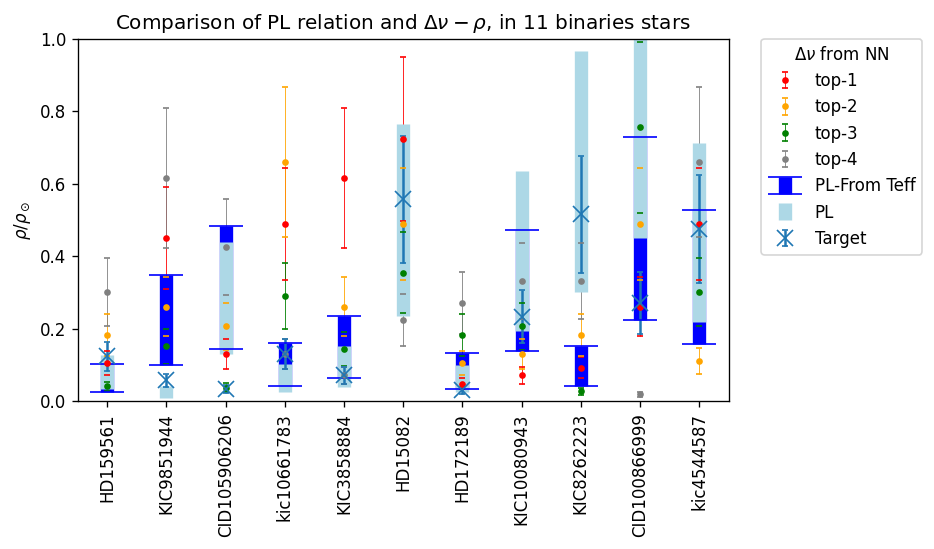

In [14]:
plt.subplots(1, figsize=(7, 4), dpi=120)

plt.errorbar(
    df["id"],
    df["rho-top-k1"],
    df["e-rho-top-k1"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="red",
    label="top-1",
)
plt.errorbar(
    df["id"],
    df["rho-top-k2"],
    df["e-rho-top-k2"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="orange",
    label="top-2",
)
plt.errorbar(
    df["id"],
    df["rho-top-k3"],
    df["e-rho-top-k3"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="green",
    label="top-3",
)
plt.errorbar(
    df["id"],
    df["rho-top-k4"],
    df["e-rho-top-k4"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="grey",
    label="top-4",
)
plt.errorbar(
    df["id"],
    (df["rho-from-P-up-fromstarmodel"] + df["rho-from-P-down-fromstarmodel"]) / 2,
    df["rho-from-P-up-fromstarmodel"] - ((df["rho-from-P-up-fromstarmodel"] + df["rho-from-P-down-fromstarmodel"]) / 2),
    elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=10,
    label="PL-From Teff",
    color="blue",
)
plt.errorbar(
    df["id"],
    (df["rho-from-P-up"] + df["rho-from-P-down"]) / 2,
    df["rho-from-P-up"] - ((df["rho-from-P-up"] + df["rho-from-P-down"]) / 2),
    elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=0,
    label="PL",
    color="lightblue",
)
plt.errorbar(
    df["id"],
    df["rho-target"],
    df["e-rho-target"],
    fmt="x",
    markersize=10,
    capsize=2,
    label="Target",
)
plt.xticks(rotation=90)

plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0,
    title=r"$\Delta\nu$ from NN",
)
#plt.gca().add_artist(legend1)

plt.ylabel("$\\rho / \\rho_\\odot$")
plt.title("Comparison of PL relation and $\Delta\\nu-\\rho$, in 11 binaries stars")
plt.ylim(0, 1.0)
plt.show()

#### calculate errors and best top-k

In [15]:
results_binaries = pd.DataFrame(
    columns=[
        "id",
        "rho-target",
        "e-rho-target",
        "rho-from-P",
        "e-rho-from-P",
        "best-top",
        "e-best-top",
        "ktop",
    ]
)

for index, row in df.iterrows():
    print("Proccessing star %s" % row["id"])
    print("PL[%f,%f]" % (row["rho-from-P-up"], row["rho-from-P-down"]))
    top_indexs = ["rho-top-k1", "rho-top-k2", "rho-top-k3", "rho-top-k4"]

    best = np.nan
    print("%f-%f" % (row["rho-from-P-up"], row["rho-from-P-down"]))
    for top_index in top_indexs:
        top_up = row[top_index] + row["e-%s" % top_index]
        top_down = row[top_index] - row["e-%s" % top_index]
        print("[%f  -  %f]" % (top_up, top_down))
        if (top_up <= row["rho-from-P-up"] and top_up >= row["rho-from-P-down"]) or (
            top_down <= row["rho-from-P-up"] and top_down >= row["rho-from-P-down"]) or(
            top_down <= row["rho-from-P-down"] and top_up >= row["rho-from-P-up"]    
            ):
            print(" * %s is the PL-rho range" % top_index)
            if np.isnan(best):
                print("   => Saving most probabily rho of NN: %f" % row[top_index])
                best = row[top_index]
                results_binaries.loc[len(results_binaries)] = [
                    row["id"],
                    row["rho-target"],
                    row["e-rho-target"],
                    (row["rho-from-P-up"] + row["rho-from-P-down"]) / 2,
                    row["rho-from-P-up"] - ((row["rho-from-P-up"] + row["rho-from-P-down"]) / 2),
                    row[top_index],
                    row["e-%s" % top_index],
                    top_index.split("-")[2]
                ]
    if np.isnan(best):
        print("<<<<<<===>>>>>>")
        results_binaries.loc[len(results_binaries)] = [
                    row["id"],
                    row["rho-target"],
                    row["e-rho-target"],
                    (row["rho-from-P-up"] + row["rho-from-P-down"]) / 2,
                    row["rho-from-P-up"] - ((row["rho-from-P-up"] + row["rho-from-P-down"]) / 2),
                    row["rho-top-k1"],
                    row["e-%s" % "rho-top-k1"],
                    "rho-top-k1".split("-")[2]
                ]
        

results_binaries

Proccessing star HD159561
PL[0.127537,0.033461]
0.127537-0.033461
[0.138376  -  0.071612]
 * rho-top-k1 is the PL-rho range
   => Saving most probabily rho of NN: 0.104994
[0.239973  -  0.124736]
 * rho-top-k2 is the PL-rho range
[0.054345  -  0.027855]
 * rho-top-k3 is the PL-rho range
[0.396320  -  0.206653]
Proccessing star KIC9851944
PL[0.041151,0.009489]
0.041151-0.009489
[0.592174  -  0.309373]
[0.344015  -  0.179235]
[0.199782  -  0.103705]
[0.808189  -  0.422705]
<<<<<<===>>>>>>
Proccessing star CID105906206
PL[0.440279,0.130020]
0.440279-0.130020
[0.172075  -  0.089217]
 * rho-top-k1 is the PL-rho range
   => Saving most probabily rho of NN: 0.130646
[0.272558  -  0.141797]
 * rho-top-k2 is the PL-rho range
[0.049489  -  0.025338]
[0.559463  -  0.292213]
 * rho-top-k4 is the PL-rho range
Proccessing star kic10661783
PL[0.102256,0.026196]
0.102256-0.026196
[0.643002  -  0.336038]
[0.867493  -  0.453819]
[0.382893  -  0.199614]
[0.172075  -  0.089217]
 * rho-top-k4 is the PL-rho

,id,rho-target,e-rho-target,rho-from-P,e-rho-from-P,best-top,e-best-top,ktop
0,HD159561,0.123968,0.039335,0.080499,0.047038,0.104994,0.033382,k1
1,KIC9851944,0.057596,0.018463,0.025320,0.015831,0.450773,0.141401,k1
2,CID105906206,0.033902,0.010961,0.285149,0.155130,0.130646,0.041429,k1
3,kic10661783,0.130646,0.041429,0.064226,0.038030,0.130646,0.041429,k4
4,KIC3858884,0.071811,0.022947,0.096073,0.055562,0.144534,0.045781,k3
5,HD15082,0.557684,0.174734,0.500601,0.264707,0.723452,0.226416,k1
6,HD172189,0.030565,0.009899,0.062451,0.037040,0.048997,0.015746,k1
7,KIC10080943,0.233600,0.073637,0.414092,0.220993,0.207177,0.065380,k3
8,KIC8262223,0.516247,0.161815,0.633855,0.331540,0.333256,0.104747,k4
9,CID100866999,0.271323,0.085418,0.926476,0.476960,0.489520,0.153482,k2


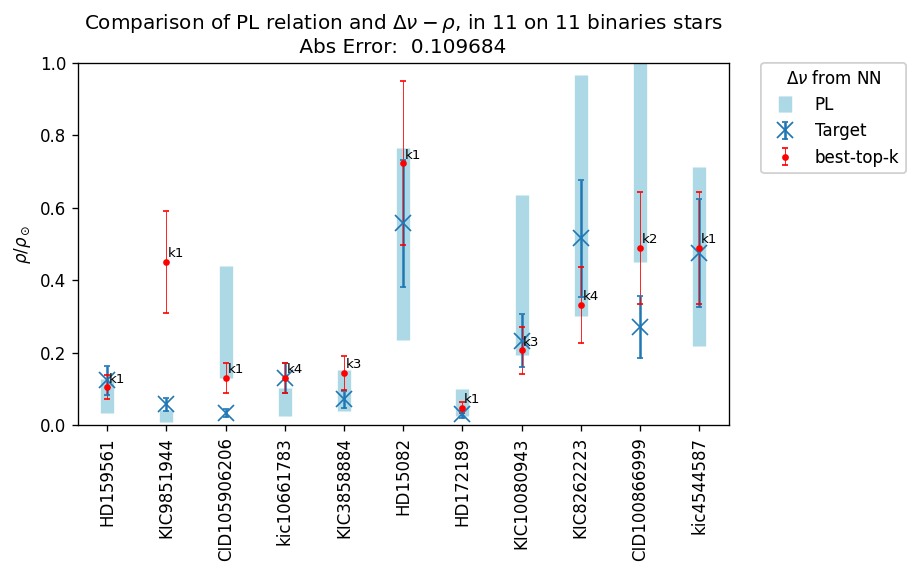

In [16]:
plt.subplots(1, figsize=(7, 4), dpi=120)
plt.errorbar(
    results_binaries["id"],
    results_binaries["rho-from-P"],
    results_binaries["e-rho-from-P"],
    elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=0,
    label="PL",
    color="lightblue",
)
plt.errorbar(
    results_binaries["id"],
    results_binaries["rho-target"],
    results_binaries["e-rho-target"],
    fmt="x",
    markersize=10,
    capsize=2,
    label="Target"
)
plt.errorbar(
    results_binaries["id"],
    results_binaries["best-top"],
    results_binaries["e-best-top"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="red",
    label="best-top-k",
)
for xpos, ypos, name in zip(results_binaries["id"], results_binaries["best-top"], results_binaries["ktop"]):
    plt.annotate(name, (xpos, ypos), xytext=(1, 1), va='bottom', textcoords='offset points', size=8)

plt.xticks(rotation=90)

legend1 = plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0,
    title=r"$\Delta\nu$ from NN",
)
plt.gca().add_artist(legend1)

binaries_abs_error = np.mean(np.abs(results_binaries["rho-target"] - results_binaries["best-top"]))
plt.ylabel("$\\rho / \\rho_\\odot$")
plt.title("Comparison of PL relation and $\Delta\\nu-\\rho$, in %d on 11 binaries stars\n Abs Error:  %f " % (len(results_binaries), binaries_abs_error))

plt.ylim(0, 1.0)
plt.show()

## Read and process Bedding stars 

In [17]:
# Read datasets of preprocessed stars
bedding_stars = bedding()
df_bedding = bedding_stars.load("../data/bedding/preprocessed/*", batch_size=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the ver

#### Read L from file

In [18]:
"""
df_att = pd.io.parsers.read_csv("../data/bedding/bedding.csv", sep=",", index_col=0)
rows = []
for i,row in pd.io.parsers.read_csv("../data/bedding/parameters.csv", sep=",", header=1, names=["star", "L", "Teff", "dnu"]).iterrows():
    print(row)
    L = df_att[df_att.TIC.eq(str(int(row["star"].split("-")[2])))]["L"].values[0]
    Teff = df_att[df_att.TIC.eq(str(int(row["star"].split("-")[2])))]["Teff"].values[0]
    rows.append([row["star"], L, Teff, row["dnu"]])
df_aux = pd.DataFrame(rows, columns = ['star', 'L', "Teff", "dnu"])  
print(df_aux.head(57))
df_aux.to_csv("../data/bedding/parameters.csv", index=False, header=True)
"""

'\ndf_att = pd.io.parsers.read_csv("../data/bedding/bedding.csv", sep=",", index_col=0)\nrows = []\nfor i,row in pd.io.parsers.read_csv("../data/bedding/parameters.csv", sep=",", header=1, names=["star", "L", "Teff", "dnu"]).iterrows():\n    print(row)\n    L = df_att[df_att.TIC.eq(str(int(row["star"].split("-")[2])))]["L"].values[0]\n    Teff = df_att[df_att.TIC.eq(str(int(row["star"].split("-")[2])))]["Teff"].values[0]\n    rows.append([row["star"], L, Teff, row["dnu"]])\ndf_aux = pd.DataFrame(rows, columns = [\'star\', \'L\', "Teff", "dnu"])  \nprint(df_aux.head(57))\ndf_aux.to_csv("../data/bedding/parameters.csv", index=False, header=True)\n'

In [19]:
df_att = pd.io.parsers.read_csv("../data/bedding/bedding.csv", sep=",", index_col=0)
df_att

,HD,Name,TIC,V,Teff,L,e.L.,rho,e.rho.,Dnu,eps,vsini,e.vsini.,F0
1,2280.0,NaN,281499618,9.13,7510.0,5.52,0.26,0.49,0.06,7.17,1.73,26.4,1.3,19.5741
2,3622.0,NaN,43363194,7.77,7930.0,7.86,0.35,0.45,0.06,6.89,1.61,50.0,6.0,17.9829
3,10779.0,NaN,229139161,8.78,7730.0,8.13,0.36,0.39,0.05,6.80,1.63,91.0,5.0,17.8840
4,10961.0,NaN,231014033,9.39,7430.0,NaN,NaN,NaN,NaN,7.30,1.70,33.0,3.0,19.7100
5,17341.0,NaN,122615966,9.32,7810.0,10.05,0.50,0.32,0.05,5.90,1.73,14.0,1.0,16.1070
6,17693.0,NaN,122686610,7.80,7880.0,10.21,0.44,0.33,0.04,6.41,1.61,NaN,NaN,16.7301
7,20203.0,NaN,274038922,8.85,7970.0,8.06,0.38,0.45,0.05,7.20,1.76,40.0,25.0,19.8720
8,20232.0,NaN,159895674,6.88,8060.0,8.64,0.36,0.44,0.05,6.86,1.64,37.0,3.0,18.1104
9,24572.0,NaN,242944780,9.45,7410.0,7.25,0.36,0.35,0.05,7.20,1.58,NaN,NaN,18.5760
10,24975.0,NaN,44645679,7.24,7790.0,9.20,0.39,0.35,0.04,6.23,1.58,88.0,4.0,16.0734


In [20]:
# Save results and predictions
results = {}
for star in df_bedding.take(57):  # take the stars
    target = np.where(star[2].numpy().flat == 1)[0].flat[0] / 0.0864
    # Save results
    if star[0].numpy()[0].decode("utf-8") not in results:
        results[star[0].numpy()[0].decode("utf-8")] = {
            "inference": sepconv_mod.predict_classes(star[1]),
            "target": target,
        }

    probs = sepconv_mod.predict_proba(star[1])[0]
    peaks, _ = find_peaks(probs, height=0, distance=10)
    peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]

    # save top-k
    results[star[0].numpy()[0].decode("utf-8")]["top-k1"] = np.where(
        probs == peaks_sorted_by_prob[0]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["top-k2"] = np.where(
        probs == peaks_sorted_by_prob[1]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["top-k3"] = np.where(
        probs == peaks_sorted_by_prob[2]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["top-k4"] = np.where(
        probs == peaks_sorted_by_prob[3]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk1"] = probs[
        np.where(probs == peaks_sorted_by_prob[0])[0][0]
    ]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk2"] = probs[
        np.where(probs == peaks_sorted_by_prob[1])[0][0]
    ]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk3"] = probs[
        np.where(probs == peaks_sorted_by_prob[2])[0][0]
    ]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk4"] = probs[
        np.where(probs == peaks_sorted_by_prob[3])[0][0]
    ]

    # Get rho
    results[star[0].numpy()[0].decode("utf-8")]["rho-target"] = get_rho(
        target / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k1"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k1"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k2"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k2"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k3"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k3"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k4"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k4"] / dnu_sun
    )

    # Get errors in rho
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-target"] = rho_error(
        target / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k1"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k1"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k2"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k2"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k3"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k3"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k4"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k4"] / dnu_sun
    )

    # Get L from Teff,Dnu model
    L = df_att[
        df_att.TIC.eq(str(int(star[0].numpy()[0].decode("utf-8").split("-")[2])))
    ]["L"].values
    Teff = df_att[
        df_att.TIC.eq(str(int(star[0].numpy()[0].decode("utf-8").split("-")[2])))
    ]["Teff"].values
    if len(Teff) > 0 and not np.isnan(Teff):

        l_teff_topk1 = gam_teff_dnu.predict(
            np.asarray(
                [results[star[0].numpy()[0].decode("utf-8")]["top-k1"], Teff]
            ).reshape(1, 2)
        )[0]
        l_teff_topk2 = gam_teff_dnu.predict(
            np.asarray(
                [results[star[0].numpy()[0].decode("utf-8")]["top-k2"], Teff]
            ).reshape(1, 2)
        )[0]
        l_teff_topk3 = gam_teff_dnu.predict(
            np.asarray(
                [results[star[0].numpy()[0].decode("utf-8")]["top-k3"], Teff]
            ).reshape(1, 2)
        )[0]
        l_teff_topk4 = gam_teff_dnu.predict(
            np.asarray(
                [results[star[0].numpy()[0].decode("utf-8")]["top-k4"], Teff]
            ).reshape(1, 2)
        )[0]

        # Get L errors
        ls_teff_topks = [l_teff_topk1, l_teff_topk2, l_teff_topk3, l_teff_topk4]
        # Get L errors
        errors = [
            round(np.power(l_teff_topk1 - L[0], 2), 2),
            round(np.power(l_teff_topk2 - L[0], 2), 2),
            round(np.power(l_teff_topk3 - L[0], 2), 2),
            round(np.power(l_teff_topk4 - L[0], 2), 2),
        ]
        i = np.argmin(errors)  # Get min error position
        L = ls_teff_topks[i]  # Get most probable L from the model

        P = get_P(np.log10(L))
        p_e = p_error(log_L=np.log10(L))
        rho_q_up = get_rho_from_P(P - p_e, Q=0.042)
        rho_q_down = get_rho_from_P(P + p_e, Q=0.033)

        results[star[0].numpy()[0].decode("utf-8")][
            "rho-from-P-up-fromstarmodel"
        ] = rho_q_up
        results[star[0].numpy()[0].decode("utf-8")][
            "rho-from-P-down-fromstarmodel"
        ] = rho_q_down
    else:
        results[star[0].numpy()[0].decode("utf-8")][
            "rho-from-P-up-fromstarmodel"
        ] = np.nan
        results[star[0].numpy()[0].decode("utf-8")][
            "rho-from-P-down-fromstarmodel"
        ] = np.nan

    # Get P from L
    L = df_att[
        df_att.TIC.eq(str(int(star[0].numpy()[0].decode("utf-8").split("-")[2])))
    ]["L"].values

    # Check for non L in csv or NaN value
    if len(L) > 0 and not np.isnan(L):
        P = get_P(np.log10(L[0]))
        p_e = p_error(log_L=np.log10(L[0]))
        # p_e=0

        rho_q_up = get_rho_from_P(P - p_e, Q=0.042)
        rho_q_down = get_rho_from_P(P + p_e, Q=0.033)
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-up"] = rho_q_up
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-down"] = rho_q_down
    else:
        print(star[0].numpy()[0].decode("utf-8"))
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-up"] = np.nan
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-down"] = np.nan

    rho_from_file = df_att[
        df_att.TIC.eq(str(int(star[0].numpy()[0].decode("utf-8").split("-")[2])))
    ]["rho"].values
    results[star[0].numpy()[0].decode("utf-8")]["rho-from-file"] = rho_from_file[0]


tess2018319095959-s0005-0000000024344701-0125-s_lc_det
tess2019058134432-s0009-0000000463556278-0139-s_lc_det
tess2018234235059-s0002-0000000327996759-0121-s_lc_det
tess2019058134432-s0009-0000000388351327-0139-s_lc_det
tess2019032160000-s0008-0000000176400189-0136-s_lc_det
tess2019169103026-s0013-0000000269792989-0146-s_lc_det
tess2018319095959-s0005-0000000306773428-0125-s_lc_det
tess2018319095959-s0005-0000000459942890-0125-s_lc_det
tess2018234235059-s0002-0000000316806320-0121-s_lc_det
tess2018319095959-s0005-0000000009147509-0125-s_lc_det
tess2018263035959-s0003-0000000231014033-0123-s_lc_det


In [21]:
df = pd.DataFrame(
    columns=[
        "id",
        "rho-target",
        "e-rho-target",
        "rho-from-P-up-fromstarmodel",
        "rho-from-P-down-fromstarmodel",
        "rho-top-k1",
        "e-rho-top-k1",
        "rho-top-k2",
        "e-rho-top-k2",
        "rho-top-k3",
        "e-rho-top-k3",
        "rho-top-k4",
        "e-rho-top-k4",
        "rho-from-P-up",
        "rho-from-P-down",

    ]
)
for i, id in enumerate(results):
    df.loc[i] = [
        id,
        results[id]["rho-target"],
        results[id]["e-rho-target"],
        results[id]["rho-from-P-up-fromstarmodel"],
        results[id]["rho-from-P-down-fromstarmodel"],
        results[id]["rho-top-k1"],
        results[id]["e-rho-top-k1"],
        results[id]["rho-top-k2"],
        results[id]["e-rho-top-k2"],
        results[id]["rho-top-k3"],
        results[id]["e-rho-top-k3"],
        results[id]["rho-top-k4"],
        results[id]["e-rho-top-k4"],
        results[id]["rho-from-P-up"],
        results[id]["rho-from-P-down"],
    ]
df

,id,rho-target,e-rho-target,rho-from-P-up-fromstarmodel,rho-from-P-down-fromstarmodel,rho-top-k1,e-rho-top-k1,rho-top-k2,e-rho-top-k2,rho-top-k3,e-rho-top-k3,rho-top-k4,e-rho-top-k4,rho-from-P-up,rho-from-P-down
0,tess2019006130736-s0007-0000000112484997-0131-...,0.419039,0.131505,0.466332,0.138372,0.425838,0.133625,0.557684,0.174734,0.281199,0.088501,0.755931,0.236542,0.537154,0.161220
1,tess2018319095959-s0005-0000000246902545-0125-...,0.419039,0.131505,0.317211,0.091042,0.413639,0.129821,0.104994,0.033382,0.207177,0.065380,0.041100,0.013245,0.284181,0.080747
2,tess2018263035959-s0003-0000000043363194-0123-...,0.419039,0.131505,0.460236,0.136415,0.261625,0.082390,0.529880,0.166065,0.676085,0.211647,0.166694,0.052719,0.554965,0.166995
3,tess2018319095959-s0005-0000000024344701-0125-...,0.572119,0.179234,NaN,NaN,0.144534,0.045781,0.037414,0.012076,0.082167,0.026207,0.261625,0.082390,NaN,NaN
4,tess2018319095959-s0005-0000000031475829-0125-...,0.572119,0.179234,0.405852,0.119032,0.615447,0.192742,0.355328,0.111634,0.476425,0.149399,0.789129,0.246894,0.526951,0.157916
5,tess2018319095959-s0005-0000000071134596-0125-...,0.572119,0.179234,0.238977,0.066805,0.660656,0.206837,0.137502,0.043577,0.355328,0.111634,0.252105,0.079417,0.366877,0.106666
6,tess2019058134432-s0009-0000000463556278-0139-...,0.572119,0.179234,NaN,NaN,0.557684,0.174734,0.130646,0.041429,0.333256,0.104747,0.215807,0.068077,NaN,NaN
7,tess2018349182459-s0006-0000000124429243-0126-...,0.419039,0.131505,0.279903,0.079420,0.450773,0.141401,0.301486,0.094834,0.755931,0.236542,0.166694,0.052719,0.294788,0.084044
8,tess2018319095959-s0005-0000000044645679-0125-...,0.419039,0.131505,0.412085,0.121017,0.333256,0.104747,0.151743,0.048039,0.586206,0.183626,0.789129,0.246894,0.452498,0.133933
9,tess2018319095959-s0005-0000000100531058-0125-...,0.419039,0.131505,0.316626,0.090859,0.130646,0.041429,0.557684,0.174734,0.333256,0.104747,0.233600,0.073637,0.387092,0.113070


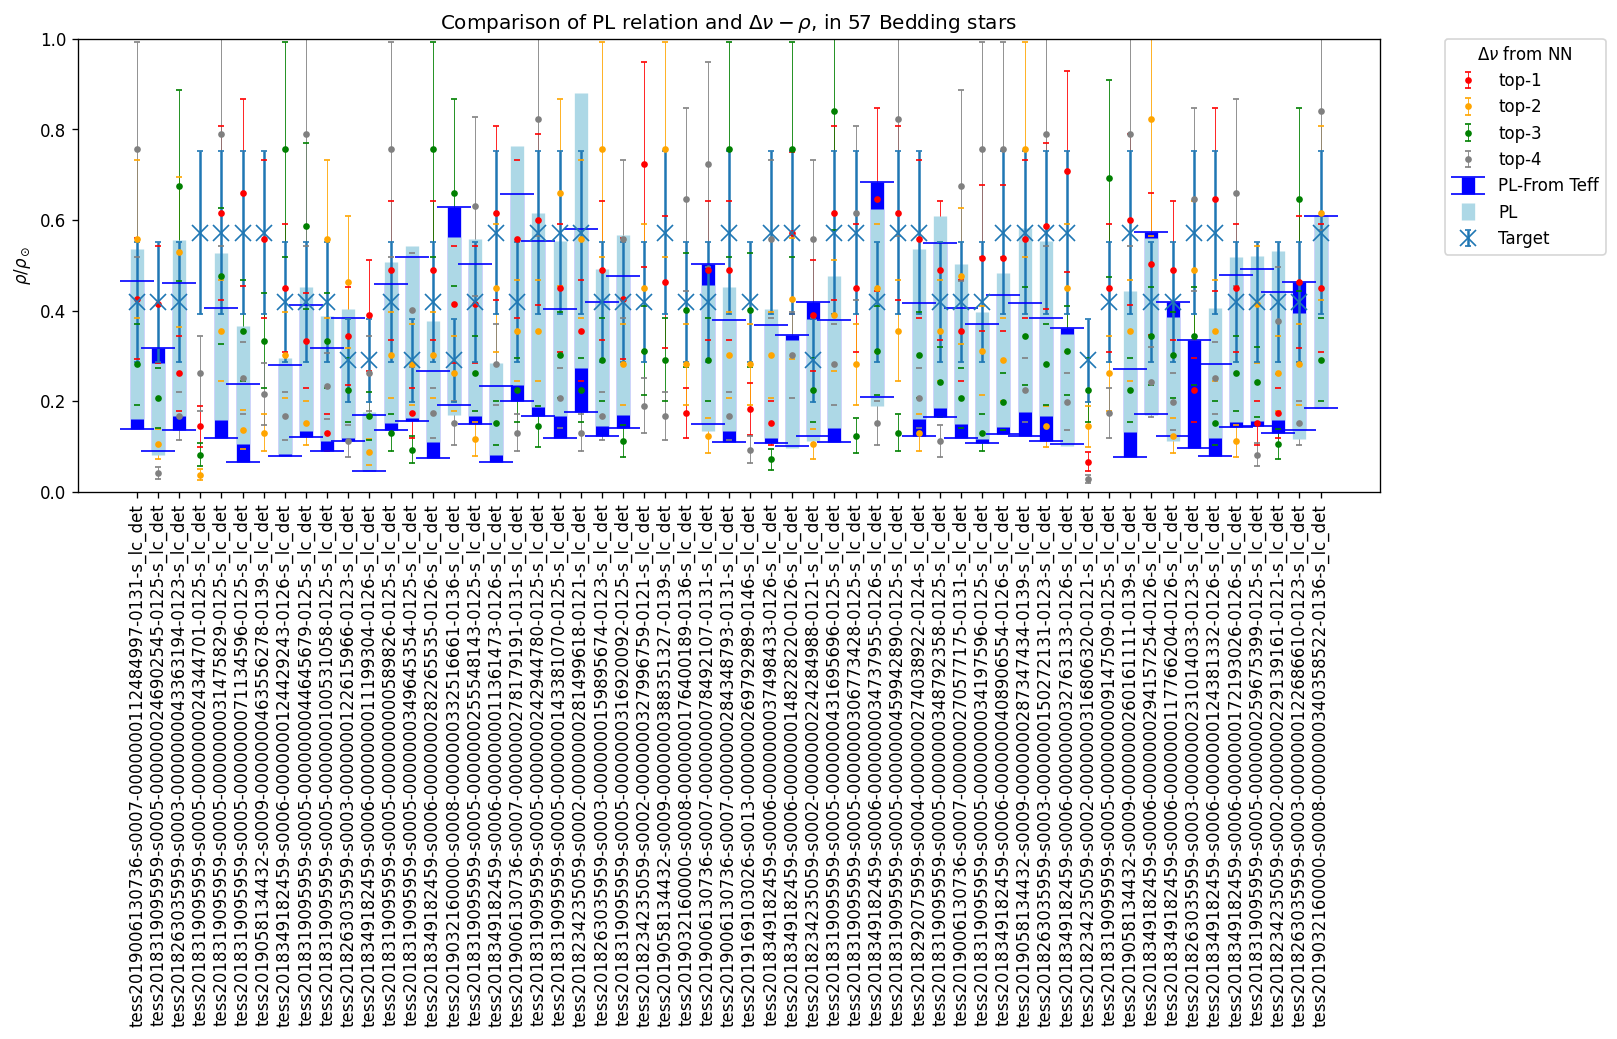

57


In [22]:
plt.subplots(1, figsize=(14, 5), dpi=120)

#plt.scatter(df["id"], df["rho-from-file"], color="black", label="rho Bedding", s=90)
plt.errorbar(
    df["id"],
    df["rho-top-k1"],
    df["e-rho-top-k1"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="red",
    label="top-1",
)
plt.errorbar(
    df["id"],
    df["rho-top-k2"],
    df["e-rho-top-k2"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="orange",
    label="top-2",
)
plt.errorbar(
    df["id"],
    df["rho-top-k3"],
    df["e-rho-top-k3"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="green",
    label="top-3",
)
plt.errorbar(
    df["id"],
    df["rho-top-k4"],
    df["e-rho-top-k4"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="grey",
    label="top-4",
)
plt.errorbar(
    df["id"],
    (df["rho-from-P-up-fromstarmodel"] + df["rho-from-P-down-fromstarmodel"]) / 2,
    df["rho-from-P-up-fromstarmodel"] - ((df["rho-from-P-up-fromstarmodel"] + df["rho-from-P-down-fromstarmodel"]) / 2),
    elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=10,
    label="PL-From Teff",
    color="blue",
)
plt.errorbar(
    df["id"],
    (df["rho-from-P-up"] + df["rho-from-P-down"]) / 2,
    df["rho-from-P-up"] - ((df["rho-from-P-up"] + df["rho-from-P-down"]) / 2),
    elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=0,
    label="PL",
    color="lightblue",
)
plt.errorbar(
    df["id"],
    df["rho-target"],
    df["e-rho-target"],
    fmt="x",
    markersize=10,
    capsize=2,
    label="Target",
)

plt.xticks(rotation=90)

plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0,
    title=r"$\Delta\nu$ from NN",
)

plt.ylabel("$\\rho / \\rho_\\odot$")
plt.title("Comparison of PL relation and $\Delta\\nu-\\rho$, in 57 Bedding stars")
plt.ylim(0, 1.0)
plt.show()

print(len(df.index))

In [23]:
results_bedding = pd.DataFrame(
    columns=[
        "id",
        "rho-target",
        "e-rho-target",
        "rho-from-P",
        "e-rho-from-P",
        "best-top",
        "e-best-top",
        "ktop",
    ]
)

top_indexs = ["rho-top-k1", "rho-top-k2", "rho-top-k3", "rho-top-k4"]
for index, row in df.iterrows():
    print("Proccessing star %s" % row["id"])
    print("PL[%f,%f]" % (row["rho-from-P-up"], row["rho-from-P-down"]))
    best = np.nan
    for top_index in top_indexs:
        top_up = row[top_index] + row["e-%s" % top_index]
        top_down = row[top_index] - row["e-%s" % top_index]
        if (top_up <= row["rho-from-P-up"] and top_up >= row["rho-from-P-down"]) or (
            top_down <= row["rho-from-P-up"] and top_down >= row["rho-from-P-down"]) or(
            top_down <= row["rho-from-P-down"] and top_up >= row["rho-from-P-up"]    
            ):
            print(" * %s is the PL-rho range" % top_index)
            if np.isnan(best):
                print("   => Saving most probabily rho of NN: %f" % row[top_index])
                best = row[top_index]
                results_bedding.loc[len(results_bedding)] = [
                    row["id"],
                    row["rho-target"],
                    row["e-rho-target"],
                    (row["rho-from-P-up"] + row["rho-from-P-down"]) / 2,
                    row["rho-from-P-up"] - ((row["rho-from-P-up"] + row["rho-from-P-down"]) / 2),
                    row[top_index],
                    row["e-%s" % top_index],
                    top_index.split("-")[2]
                ]
    #if np.isnan(best):
    if True:
        print("not match!")
        print((top_up <= row["rho-from-P-up"] and top_up >= row["rho-from-P-down"]))
        print((top_down <= row["rho-from-P-up"] and top_down >= row["rho-from-P-down"]))
        print(row[top_index])
        print(top_up)
        print(top_down)
        top_index="rho-top-k1"
        top_up = row[top_index] + row["e-%s" % top_index]
        top_down = row[top_index] - row["e-%s" % top_index]
        if True:
            if np.isnan(best):
                print("   => Saving by-default rho of NN: %f" % row[top_index])
                best = row[top_index]
                results_bedding.loc[len(results_bedding)] = [
                    row["id"],
                    row["rho-target"],
                    row["e-rho-target"],
                    (row["rho-from-P-up"] + row["rho-from-P-down"]) / 2,
                    row["rho-from-P-up"] - ((row["rho-from-P-up"] + row["rho-from-P-down"]) / 2),
                    row[top_index],
                    row["e-%s" % top_index],
                    top_index.split("-")[2]
                ]

results_bedding
print(len(results_bedding))

Proccessing star tess2019006130736-s0007-0000000112484997-0131-s_lc_det
PL[0.537154,0.161220]
 * rho-top-k1 is the PL-rho range
   => Saving most probabily rho of NN: 0.425838
 * rho-top-k2 is the PL-rho range
 * rho-top-k3 is the PL-rho range
 * rho-top-k4 is the PL-rho range
not match!
False
True
0.7559306532534369
0.9924730916886411
0.5193882148182327
Proccessing star tess2018319095959-s0005-0000000246902545-0125-s_lc_det
PL[0.284181,0.080747]
 * rho-top-k1 is the PL-rho range
   => Saving most probabily rho of NN: 0.413639
 * rho-top-k2 is the PL-rho range
 * rho-top-k3 is the PL-rho range
not match!
False
False
0.0410998479953631
0.05434485329477257
0.027854842695953626
Proccessing star tess2018263035959-s0003-0000000043363194-0123-s_lc_det
PL[0.554965,0.166995]
 * rho-top-k1 is the PL-rho range
   => Saving most probabily rho of NN: 0.261625
 * rho-top-k2 is the PL-rho range
 * rho-top-k3 is the PL-rho range
 * rho-top-k4 is the PL-rho range
not match!
True
False
0.16669432197131

##### get $\Delta\nu$ from the $\rho$ provided in Bedding

In [24]:
results_bedding["dnu-target"] = results_bedding["rho-target"].apply(get_dnu_from_rho) * dnu_sun
results_bedding["e-dnu-target"] = results_bedding["rho-target"].apply(dnu_error) * dnu_sun

results_bedding["dnu-best_top"] = results_bedding["best-top"].apply(get_dnu_from_rho) * dnu_sun

results_bedding["dnu-from-P"] = (results_bedding["rho-from-P"]).apply(get_dnu_from_rho) * dnu_sun
results_bedding["dnu-from-P-up"] = (results_bedding["rho-from-P"]+results_bedding["e-rho-from-P"]).apply(get_dnu_from_rho) * dnu_sun
results_bedding["e-dnu-from-P"] = results_bedding["dnu-from-P-up"] - results_bedding["dnu-from-P"]
results_bedding

,id,rho-target,e-rho-target,rho-from-P,e-rho-from-P,best-top,e-best-top,ktop,dnu-target,e-dnu-target,dnu-best_top,dnu-from-P,dnu-from-P-up,e-dnu-from-P
0,tess2019006130736-s0007-0000000112484997-0131-...,0.419039,0.131505,0.349187,0.187967,0.425838,0.133625,k1,69.444444,2.280202,70.0,63.449989,78.528288,15.078299
1,tess2018319095959-s0005-0000000246902545-0125-...,0.419039,0.131505,0.182464,0.101717,0.413639,0.129821,k1,69.444444,2.280202,69.0,46.013621,57.298455,11.284834
2,tess2018263035959-s0003-0000000043363194-0123-...,0.419039,0.131505,0.360980,0.193985,0.261625,0.082390,k1,69.444444,2.280202,55.0,64.501888,79.806657,15.304768
3,tess2018319095959-s0005-0000000024344701-0125-...,0.572119,0.179234,NaN,NaN,0.144534,0.045781,k1,81.018519,2.041965,41.0,NaN,NaN,NaN
4,tess2018319095959-s0005-0000000031475829-0125-...,0.572119,0.179234,0.342434,0.184517,0.615447,0.192742,k1,81.018519,2.041965,84.0,62.839484,77.786247,14.946763
5,tess2018319095959-s0005-0000000071134596-0125-...,0.572119,0.179234,0.236772,0.130105,0.137502,0.043577,k2,81.018519,2.041965,40.0,52.348297,65.021403,12.673106
6,tess2019058134432-s0009-0000000463556278-0139-...,0.572119,0.179234,NaN,NaN,0.557684,0.174734,k1,81.018519,2.041965,80.0,NaN,NaN,NaN
7,tess2018349182459-s0006-0000000124429243-0126-...,0.419039,0.131505,0.189416,0.105372,0.301486,0.094834,k2,69.444444,2.280202,59.0,46.873285,58.347354,11.474069
8,tess2018319095959-s0005-0000000044645679-0125-...,0.419039,0.131505,0.293216,0.159282,0.333256,0.104747,k1,69.444444,2.280202,62.0,58.193109,72.136223,13.943115
9,tess2018319095959-s0005-0000000100531058-0125-...,0.419039,0.131505,0.250081,0.137011,0.130646,0.041429,k1,69.444444,2.280202,39.0,53.784917,66.771055,12.986138


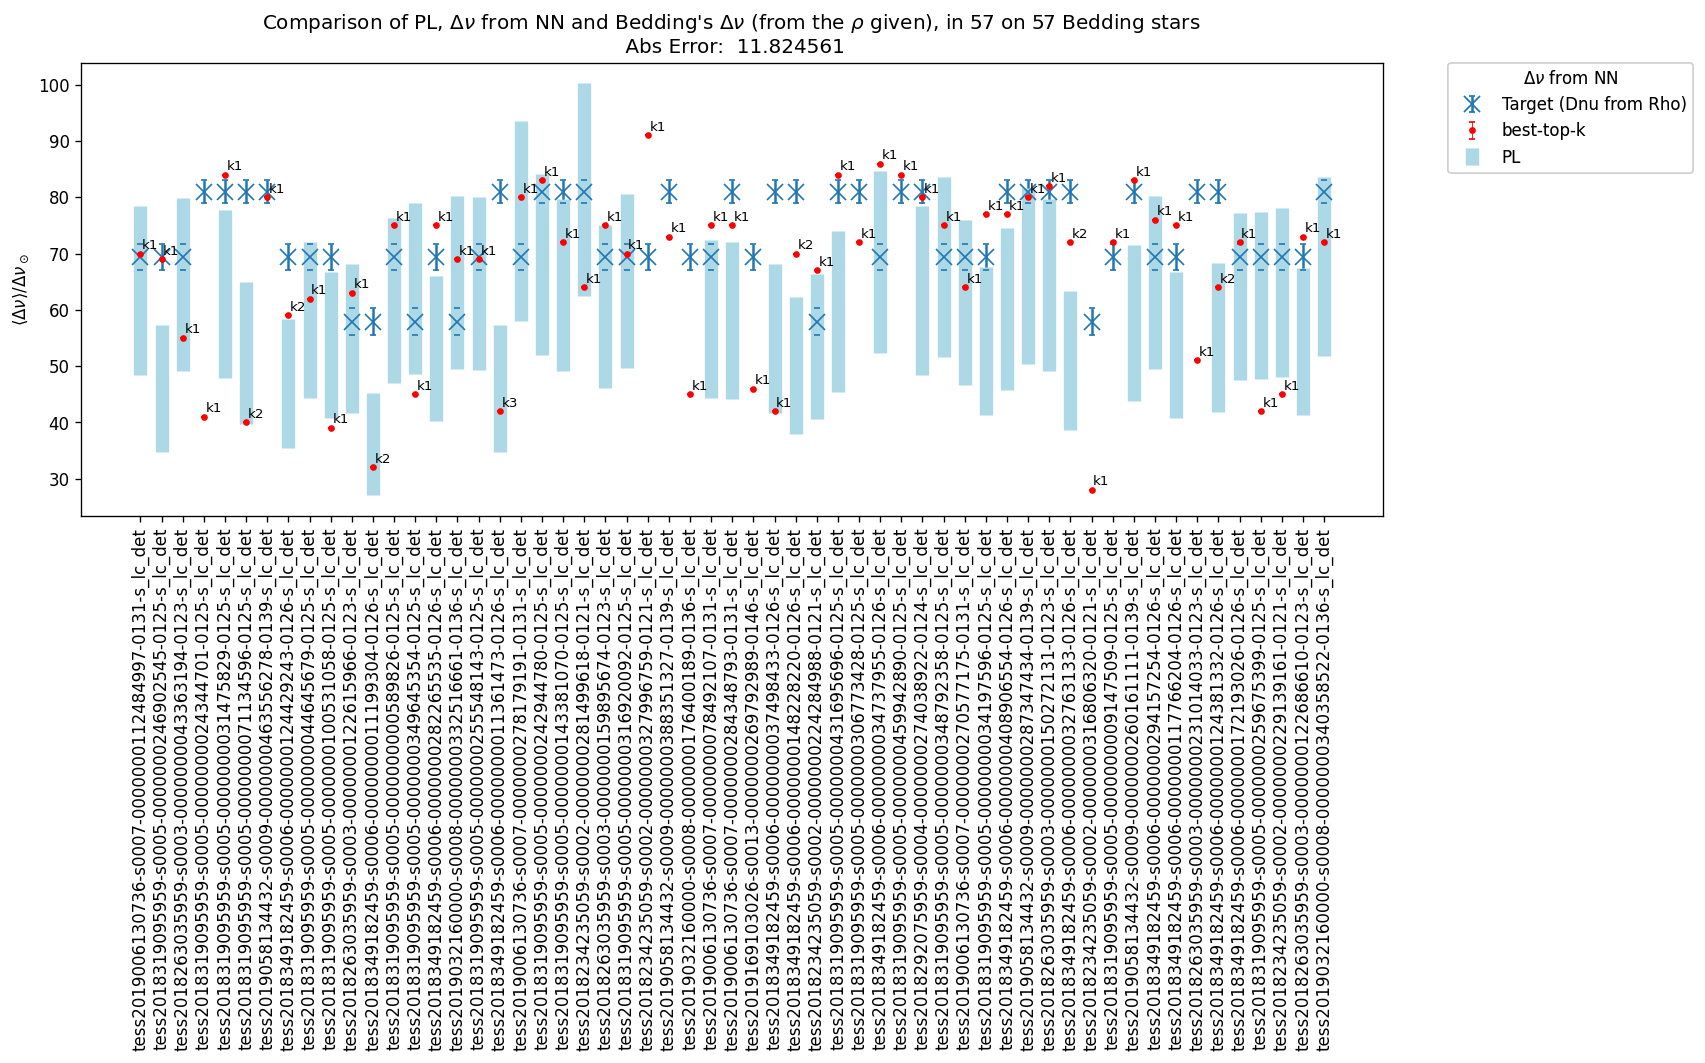

In [25]:
plt.subplots(1, figsize=(14, 5), dpi=120)
plt.errorbar(results_bedding["id"], results_bedding["dnu-target"], results_bedding["e-dnu-target"],  fmt="x",
    markersize=10,
    capsize=2,
    label="Target (Dnu from Rho)")
plt.errorbar(results_bedding["id"], results_bedding["dnu-best_top"], 0,  elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="red",
    label="best-top-k")
plt.errorbar(results_bedding["id"], results_bedding["dnu-from-P"], results_bedding["e-dnu-from-P"],  elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=0,
    label="PL",
    color="lightblue",)

for xpos, ypos, name in zip(results_bedding["id"], results_bedding["dnu-best_top"], results_bedding["ktop"]):
    plt.annotate(name, (xpos, ypos), xytext=(1, 1), va='bottom', textcoords='offset points', size=8)
plt.xticks(rotation=90)

legend1 = plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0,
    title=r"$\Delta\nu$ from NN",
)
plt.gca().add_artist(legend1)

plt.ylabel("$\langle\Delta\\nu\\rangle / \Delta\\nu_\odot$")
bedding_abs_error = np.mean(np.abs(results_bedding["dnu-target"] - results_bedding["dnu-best_top"]))
plt.title("Comparison of PL, $\Delta\\nu$ from NN and Bedding's $\Delta\\nu$ (from the $\\rho$ given), in %d on 57 Bedding stars \n Abs Error:  %f" % (len(results_bedding), bedding_abs_error))
plt.show()

In [26]:
print(np.mean(np.abs(results_bedding["dnu-target"] - results_bedding["dnu-best_top"])))
print(np.mean(np.abs(results_bedding["dnu-target"] - results_bedding["dnu-from-P"])))
print(np.mean(np.abs(results_bedding["dnu-best_top"] - results_bedding["dnu-from-P"])))

11.824561403508772
13.974806235444063
13.55594935315816


In [27]:
print("Coefcorr Bedding and PL: %f" % np.corrcoef(results_bedding["dnu-target"], results_bedding["dnu-from-P"])[0][1])
print("Coefcorr NN and PL: %f" % np.corrcoef(results_bedding["dnu-best_top"], results_bedding["dnu-from-P"])[0][1])

Coefcorr Bedding and PL: nan
Coefcorr NN and PL: nan


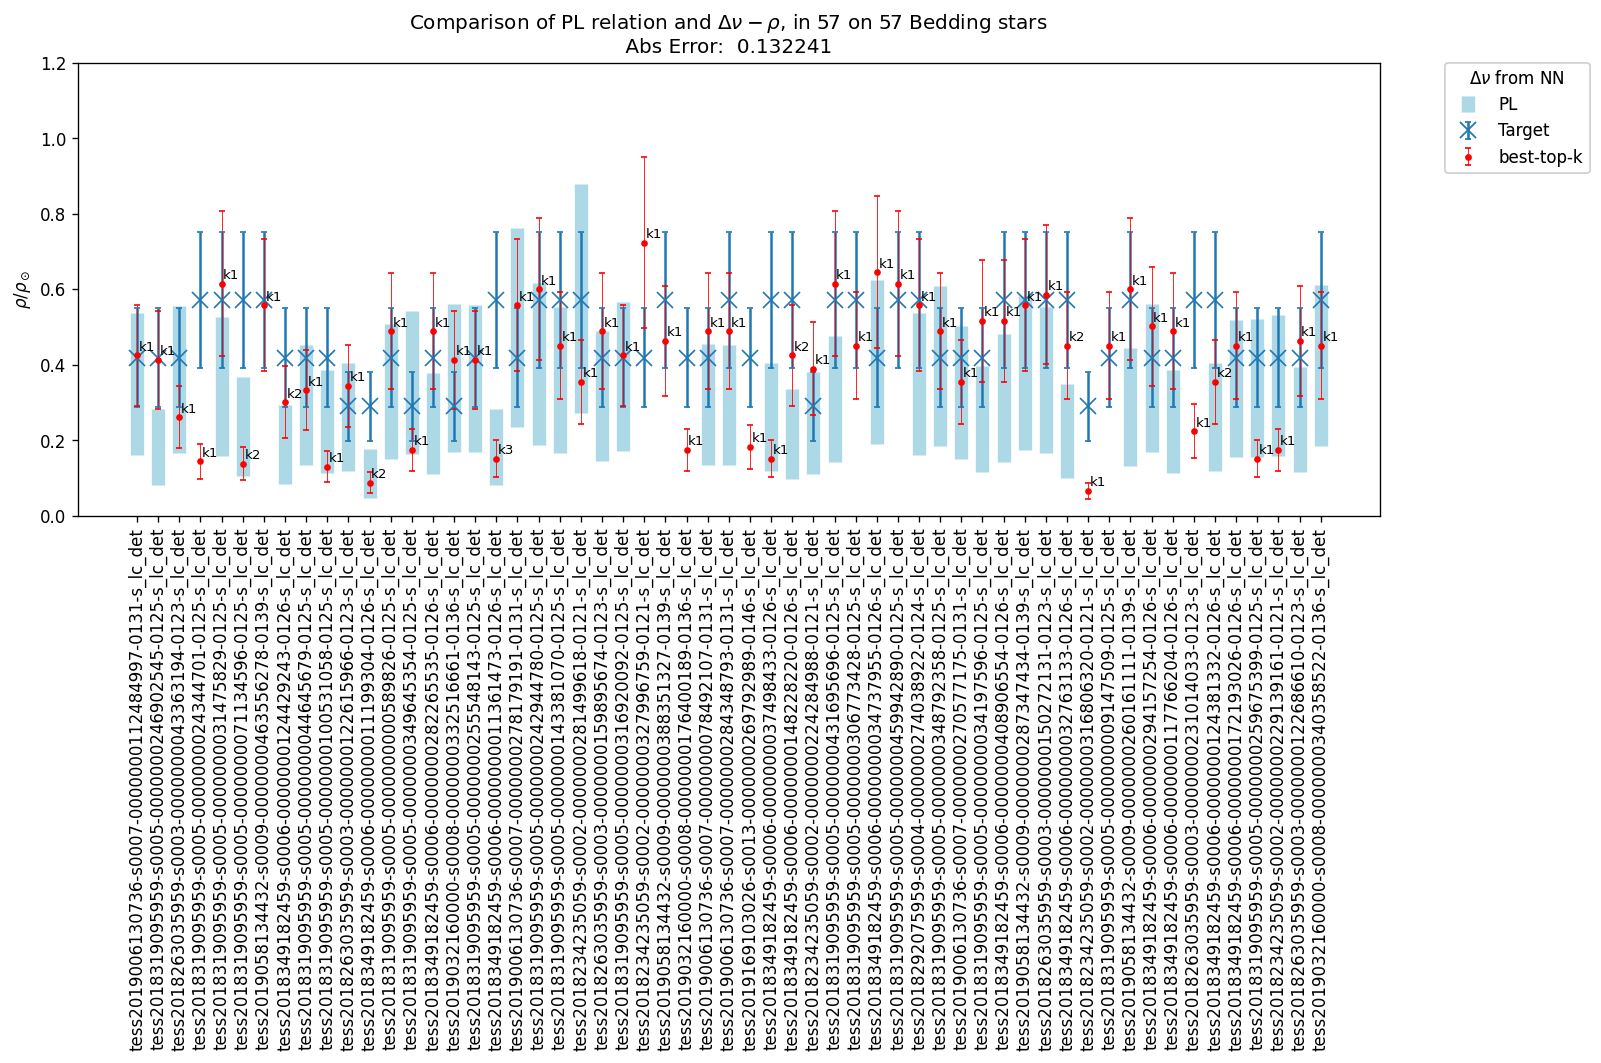

In [28]:
plt.subplots(1, figsize=(14, 5), dpi=120)
plt.errorbar(
    results_bedding["id"],
    results_bedding["rho-from-P"],
    results_bedding["e-rho-from-P"],
    elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=0,
    label="PL",
    color="lightblue",
)
plt.errorbar(
    results_bedding["id"],
    results_bedding["rho-target"],
    results_bedding["e-rho-target"],
    fmt="x",
    markersize=10,
    capsize=2,
    label="Target"
)
plt.errorbar(
    results_bedding["id"],
    results_bedding["best-top"],
    results_bedding["e-best-top"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="red",
    label="best-top-k",
)
for xpos, ypos, name in zip(results_bedding["id"], results_bedding["best-top"], results_bedding["ktop"]):
    plt.annotate(name, (xpos, ypos), xytext=(1, 1), va='bottom', textcoords='offset points', size=8)
plt.xticks(rotation=90)

legend1 = plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0,
    title=r"$\Delta\nu$ from NN",
)
plt.gca().add_artist(legend1)

plt.ylabel("$\\rho / \\rho_\\odot$")
bedding_abs_error = np.mean(np.abs(results_bedding["rho-target"] - results_bedding["best-top"]))
plt.title("Comparison of PL relation and $\Delta\\nu-\\rho$, in %d on 57 Bedding stars \n Abs Error:  %f " % (len(results_bedding), bedding_abs_error))
np.mean(np.abs(results_bedding["rho-target"] - results_bedding["best-top"]))
plt.ylim(0, 1.2)
plt.show()

## Read and process Paparó stars 

In [29]:
# Read datasets of preprocessed stars
df_cor = corot()
dfcor = df_cor.load("../../astronn/data/corot/preprocessed/*.log", batch_size=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the ver

In [30]:
# Preprocess 77 CoRoT stars
from astronn.preprocess import predeltascuti, precorot
if False:
    preprocessor = precorot(conf_file="../../astronn/data/corot/parameters.csv", cols=["corot", "loggs", "teff", "l"])
    preprocessor.preprocess_files(
        input_folder="../../astronn/data/corot/raw/*",
        output_folder="../../astronn/data/corot/preprocessed/",
    )

In [31]:
vrrhosun = 1.409
vrloggsun = 4.44

def get_radio_from_rho(rho, e_rho):
    """
    calculate radio from rho, estimating max and min values
    """
    R_min = (1.5 / (rho + e_rho) / vrrhosun) ** (1 / 3)
    R_max = (3 / (rho - e_rho) / vrrhosun) ** (1 / 3)
    return {"r_min": R_min, "r_max": R_max}


def get_logg_from_radio(R_max, R_min):
    """
    calculate logg from radio estimating max and min values
    """
    logg_min = np.log10(1.5 / R_max ** 2) + vrloggsun
    logg_max = np.log10(3 / R_min ** 2) + vrloggsun
    return {"logg_min": logg_min, "logg_max": logg_max}

In [32]:
# Save results and predictions
results = {}
for star in dfcor.take(75):  # take the 75 corot stars
    x_star = star[1].numpy()
    # Star logg from data
    logg_data = star[2][0].numpy()
    vrrhosun = 1.409
    target = logg_data

    # Save results
    if star[0].numpy()[0].decode("utf-8") not in results:
        results[star[0].numpy()[0].decode("utf-8")] = {
            "inference": sepconv_mod.predict_classes(star[1]),
            "target": logg_data,
        }

    probs = sepconv_mod.predict_proba(star[1])[0]
    peaks, _ = find_peaks(probs, height=0, distance=10)
    peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]

    # save top-k
    results[star[0].numpy()[0].decode("utf-8")]["top-k1"] = np.where(
        probs == peaks_sorted_by_prob[0]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["top-k2"] = np.where(
        probs == peaks_sorted_by_prob[1]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["top-k3"] = np.where(
        probs == peaks_sorted_by_prob[2]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["top-k4"] = np.where(
        probs == peaks_sorted_by_prob[3]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk1"] = probs[
        np.where(probs == peaks_sorted_by_prob[0])[0][0]
    ]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk2"] = probs[
        np.where(probs == peaks_sorted_by_prob[1])[0][0]
    ]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk3"] = probs[
        np.where(probs == peaks_sorted_by_prob[2])[0][0]
    ]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk4"] = probs[
        np.where(probs == peaks_sorted_by_prob[3])[0][0]
    ]

    # Get rho
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k1"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k1"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k2"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k2"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k3"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k3"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k4"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k4"] / dnu_sun
    )

    # Get errors in rho
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k1"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k1"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k2"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k2"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k3"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k3"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k4"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k4"] / dnu_sun
    )

    # Get radio and logg from rho
    results[star[0].numpy()[0].decode("utf-8")]["logg-target"] = target
    results[star[0].numpy()[0].decode("utf-8")]["e-logg-target"] = 0

    radios = get_radio_from_rho(results[star[0].numpy()[0].decode("utf-8")]["rho-top-k1"], results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k1"])
    loggs_condifence = get_logg_from_radio(radios["r_max"], radios["r_min"])
    loggs_average = (loggs_condifence["logg_max"] + loggs_condifence["logg_min"]) / 2
    results[star[0].numpy()[0].decode("utf-8")]["logg-top-k1"] = loggs_average
    results[star[0].numpy()[0].decode("utf-8")]["e-logg-top-k1"] = loggs_condifence["logg_max"]-loggs_average

    radios = get_radio_from_rho(results[star[0].numpy()[0].decode("utf-8")]["rho-top-k2"], results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k2"])
    loggs_condifence = get_logg_from_radio(radios["r_max"], radios["r_min"])
    loggs_average = (loggs_condifence["logg_max"] + loggs_condifence["logg_min"]) / 2
    results[star[0].numpy()[0].decode("utf-8")]["logg-top-k2"] = loggs_average
    results[star[0].numpy()[0].decode("utf-8")]["e-logg-top-k2"] = loggs_condifence["logg_max"]-loggs_average

    radios = get_radio_from_rho(results[star[0].numpy()[0].decode("utf-8")]["rho-top-k3"], results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k3"])
    loggs_condifence = get_logg_from_radio(radios["r_max"], radios["r_min"])
    loggs_average = (loggs_condifence["logg_max"] + loggs_condifence["logg_min"]) / 2
    results[star[0].numpy()[0].decode("utf-8")]["logg-top-k3"] = loggs_average
    results[star[0].numpy()[0].decode("utf-8")]["e-logg-top-k3"] = loggs_condifence["logg_max"]-loggs_average

    radios = get_radio_from_rho(results[star[0].numpy()[0].decode("utf-8")]["rho-top-k4"], results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k4"])
    loggs_condifence = get_logg_from_radio(radios["r_max"], radios["r_min"])
    loggs_average = (loggs_condifence["logg_max"] + loggs_condifence["logg_min"]) / 2
    results[star[0].numpy()[0].decode("utf-8")]["logg-top-k4"] = loggs_average
    results[star[0].numpy()[0].decode("utf-8")]["e-logg-top-k4"] = loggs_condifence["logg_max"]-loggs_average


    # Get L from Teff,Dnu model
    Teff = star[3][0].numpy()
    L = star[4][0].numpy()
    if not np.isnan(Teff):
        l_teff_topk1 = gam_teff_dnu.predict(np.asarray([results[star[0].numpy()[0].decode("utf-8")]["top-k1"] , Teff]).reshape(1,2))[0]
        l_teff_topk2 = gam_teff_dnu.predict(np.asarray([results[star[0].numpy()[0].decode("utf-8")]["top-k2"] , Teff]).reshape(1,2))[0]
        l_teff_topk3 = gam_teff_dnu.predict(np.asarray([results[star[0].numpy()[0].decode("utf-8")]["top-k3"] , Teff]).reshape(1,2))[0]
        l_teff_topk4 = gam_teff_dnu.predict(np.asarray([results[star[0].numpy()[0].decode("utf-8")]["top-k4"] , Teff]).reshape(1,2))[0]

        # Get L errors
        ls_teff_topks = [l_teff_topk1, l_teff_topk2, l_teff_topk3, l_teff_topk4]
        # Get L errors
        errors = [
                round(np.power(l_teff_topk1 - L, 2), 2),
                round(np.power(l_teff_topk2 - L, 2), 2),
                round(np.power(l_teff_topk3 - L, 2), 2),
                round(np.power(l_teff_topk4 - L, 2), 2),
            ]
        i = np.argmin(errors) # Get min error position
        L = ls_teff_topks[i] # Get most probable L from the model

        P = get_P(np.log10(L))
        p_e = p_error(log_L=np.log10(L))

        rho_q_up = get_rho_from_P(P - p_e, Q=0.042)
        rho_q_down = get_rho_from_P(P + p_e, Q=0.033)

        radios = get_radio_from_rho((rho_q_up+rho_q_down)/2, rho_q_up-((rho_q_up+rho_q_down)/2))
        loggs_condifence = get_logg_from_radio(radios["r_max"], radios["r_min"])
        loggs_average = (loggs_condifence["logg_max"] + loggs_condifence["logg_min"]) / 2
        results[star[0].numpy()[0].decode("utf-8")]["logg-from-P-fromstarmodel"] = loggs_average
        results[star[0].numpy()[0].decode("utf-8")]["e-logg-from-P-fromstarmodel"] = loggs_condifence["logg_max"] - loggs_average
    else:
        results[star[0].numpy()[0].decode("utf-8")]["logg-from-P-fromstarmodel"] = np.nan
        results[star[0].numpy()[0].decode("utf-8")]["e-logg-from-P-fromstarmodel"] = np.nan

    # Get P from L
    L = star[4][0].numpy()

    # Check for non L in csv or NaN value
    if not np.isnan(L):
        P = get_P(np.log10(L))
        p_e = p_error(log_L=np.log10(L))
        #p_e=0

        rho_q_up = get_rho_from_P(P - p_e, Q=0.042)
        rho_q_down = get_rho_from_P(P + p_e, Q=0.033)
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-up"] = rho_q_up
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-down"] = rho_q_down

        radios = get_radio_from_rho((rho_q_up+rho_q_down)/2, rho_q_up-((rho_q_up+rho_q_down)/2))
        loggs_condifence = get_logg_from_radio(radios["r_max"], radios["r_min"])
        loggs_average = (loggs_condifence["logg_max"] + loggs_condifence["logg_min"]) / 2
        results[star[0].numpy()[0].decode("utf-8")]["logg-from-P"] = loggs_average
        results[star[0].numpy()[0].decode("utf-8")]["e-logg-from-P"] = loggs_condifence["logg_max"] - loggs_average

    else:
        print(star[0].numpy()[0].decode("utf-8"))
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-up"] = np.nan
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-down"] = np.nan
        results[star[0].numpy()[0].decode("utf-8")]["logg-from-P"] = np.nan
        results[star[0].numpy()[0].decode("utf-8")]["e-logg-from-P"] = np.nan

In [33]:
df = pd.DataFrame(
    columns=[
        "id",
        "logg-target",
        "e-logg-target",
        "logg-top-k1",
        "e-logg-top-k1",
        "logg-top-k2",
        "e-logg-top-k2",
        "logg-top-k3",
        "e-logg-top-k3",
        "logg-top-k4",
        "e-logg-top-k4",
        "rho-top-k1",
        "e-rho-top-k1",
        "rho-top-k2",
        "e-rho-top-k2",
        "rho-top-k3",
        "e-rho-top-k3",
        "rho-top-k4",
        "e-rho-top-k4",
        "rho-from-P-up",
        "rho-from-P-down",
        "logg-from-P",
        "e-logg-from-P",
        "logg-from-P-fromstarmodel",
        "e-logg-from-P-fromstarmodel"
    ]
)
for i, id in enumerate(results):
    df.loc[i] = [
        id,
        results[id]["logg-target"],
        results[id]["e-logg-target"],
        results[id]["logg-top-k1"],
        results[id]["e-logg-top-k1"],
        results[id]["logg-top-k2"],
        results[id]["e-logg-top-k2"],
        results[id]["logg-top-k3"],
        results[id]["e-logg-top-k3"],
        results[id]["logg-top-k4"],
        results[id]["e-logg-top-k4"],
        results[id]["rho-top-k1"],
        results[id]["e-rho-top-k1"],
        results[id]["rho-top-k2"],
        results[id]["e-rho-top-k2"],
        results[id]["rho-top-k3"],
        results[id]["e-rho-top-k3"],
        results[id]["rho-top-k4"],
        results[id]["e-rho-top-k4"],
        results[id]["rho-from-P-up"],
        results[id]["rho-from-P-down"],
        results[id]["logg-from-P"],
        results[id]["e-logg-from-P"],
        results[id]["logg-from-P-fromstarmodel"],
        results[id]["e-logg-from-P-fromstarmodel"]
    ]
df

,id,logg-target,e-logg-target,logg-top-k1,e-logg-top-k1,logg-top-k2,e-logg-top-k2,logg-top-k3,e-logg-top-k3,logg-top-k4,...,rho-top-k3,e-rho-top-k3,rho-top-k4,e-rho-top-k4,rho-from-P-up,rho-from-P-down,logg-from-P,e-logg-from-P,logg-from-P-fromstarmodel,e-logg-from-P-fromstarmodel
0,102724195,3.900,0,4.223125,0.345308,4.086928,0.345777,4.351529,0.344960,3.783062,...,0.378116,0.118742,0.053209,0.017078,1.020112,0.320588,4.486341,0.418425,4.274514,0.425834
1,102733521,3.625,0,3.945696,0.346371,4.127326,0.345627,3.652312,0.347946,4.333519,...,0.033902,0.010961,0.355328,0.111634,0.470161,0.139603,4.253856,0.426643,4.341473,0.423314
2,102691789,3.750,0,4.582851,0.344566,4.385966,0.344882,4.506428,0.344663,4.275899,...,0.645406,0.202083,0.291253,0.091640,0.400867,0.117445,4.205755,0.428580,4.182175,0.429556
3,102575808,3.325,0,4.200606,0.345379,3.945696,0.346371,4.369001,0.344920,4.506428,...,0.401619,0.126072,0.645406,0.202083,NaN,NaN,NaN,NaN,4.351786,0.422940
4,102603176,4.300,0,3.652312,0.347946,3.909076,0.346542,4.177185,0.345455,4.314936,...,0.207177,0.065380,0.333256,0.104747,0.054810,0.013079,3.599957,0.458282,3.645313,0.455776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,102721716,4.150,0,4.582851,0.344566,4.314936,0.345050,4.441744,0.344770,4.200606,...,0.516247,0.161815,0.224615,0.070830,0.701932,0.215016,4.374398,0.422133,4.301060,0.424816
71,102591062,3.650,0,4.539493,0.344617,4.426343,0.344800,4.333519,0.345003,4.200606,...,0.355328,0.111634,0.224615,0.070830,1.316718,0.420233,4.562470,0.416192,4.322407,0.424016
72,102678628,3.225,0,3.806040,0.347064,4.072817,0.345832,4.265718,0.345183,3.399810,...,0.281199,0.088501,0.014201,0.004666,0.096684,0.024617,3.773670,0.448899,3.906118,0.442170
73,102691322,4.050,0,4.471379,0.344718,4.385966,0.344882,4.582851,0.344566,4.275899,...,0.840278,0.262845,0.291253,0.091640,NaN,NaN,NaN,NaN,4.283129,0.425501


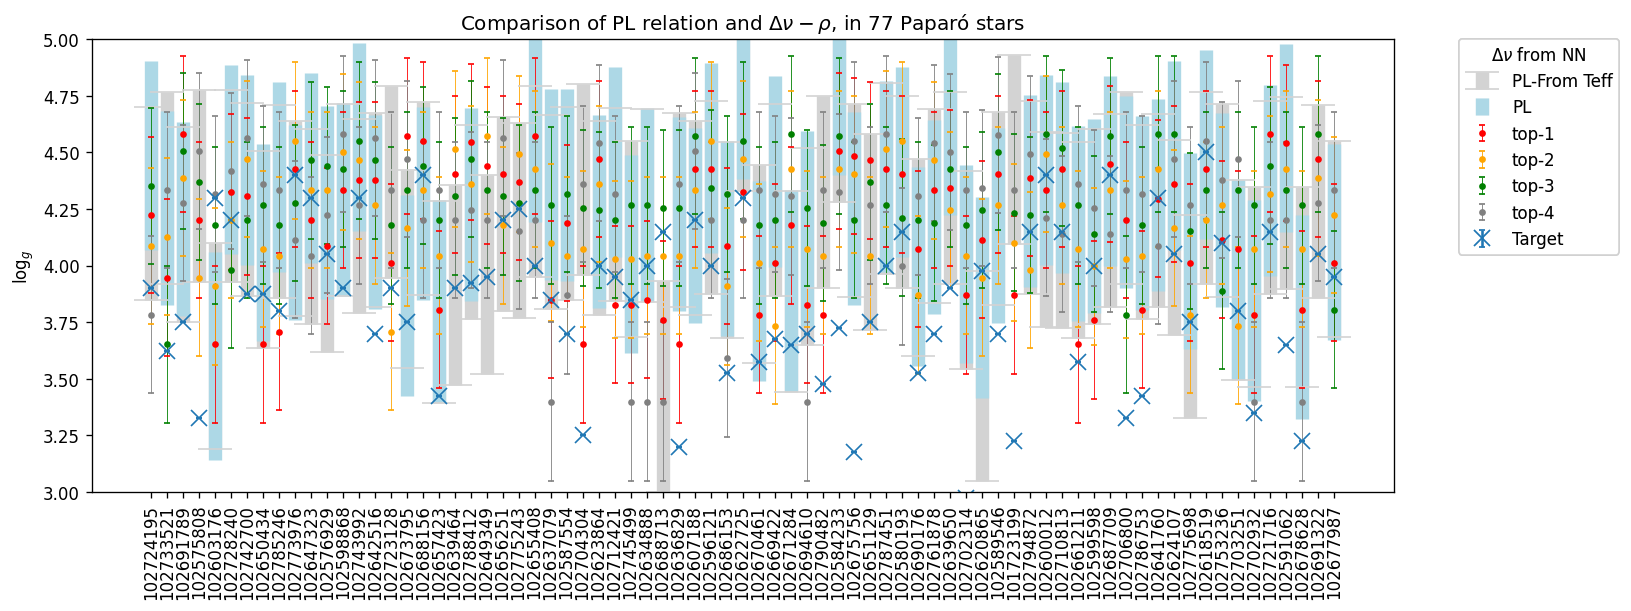

In [34]:
plt.subplots(1, figsize=(14, 5), dpi=120)

#plt.scatter(df["id"], df["rho-from-file"], color="black", label="rho Bedding", s=90)

plt.errorbar(
    df["id"],
    df["logg-from-P-fromstarmodel"],
    df["e-logg-from-P-fromstarmodel"],
    elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=10,
    label="PL-From Teff",
    color="lightgrey",
)
plt.errorbar(
    df["id"],
    df["logg-from-P"],
    df["e-logg-from-P"],
    elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=0,
    label="PL",
    color="lightblue",
)

p1,p1,p1 = plt.errorbar(
    df["id"],
    df["logg-top-k1"],
    df["e-logg-top-k1"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="red",
    label="top-1",
)
p2,_,_ = plt.errorbar(
    df["id"],
    df["logg-top-k2"],
    df["e-logg-top-k2"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="orange",
    label="top-2",
)
p3,_,_ = plt.errorbar(
    df["id"],
    df["logg-top-k3"],
    df["e-logg-top-k3"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="green",
    label="top-3",
)
p4,_,_ = plt.errorbar(
    df["id"],
    df["logg-top-k4"],
    df["e-logg-top-k4"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="grey",
    label="top-4",
)

p6,_,_ = plt.errorbar(
    df["id"],
    df["logg-target"],
    df["e-logg-target"],
    fmt="x",
    markersize=10,
    capsize=2,
    label="Target",
)

plt.xticks(rotation=90)

legend1 = plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0,
    title=r"$\Delta\nu$ from NN",
)
plt.gca().add_artist(legend1)

plt.ylabel("$\log_g$")
plt.title("Comparison of PL relation and $\Delta\\nu-\\rho$, in 77 Paparó stars")
plt.ylim(3, 5)
plt.show()

In [35]:
results_corot = pd.DataFrame(
    columns=[
        "id",
        "logg-target",
        "e-logg-target",
        "logg-from-P",
        "e-logg-from-P",
        "best-top",
        "e-best-top",
        "ktop",
    ]
)

top_indexs = ["logg-top-k1", "logg-top-k2", "logg-top-k3", "logg-top-k4"]
for index, row in df.iterrows():
    row["logg-from-P-up"] = row["logg-from-P"] + row["e-logg-from-P"]
    row["logg-from-P-down"] = row["logg-from-P"] - row["e-logg-from-P"]

    print("Proccessing star %s" % row["id"])
    print("PL[%f,%f]" % (row["logg-from-P-up"], row["logg-from-P-down"]))
    best = np.nan
    for top_index in top_indexs:
        top_up = row[top_index] + row["e-%s" % top_index]
        top_down = row[top_index] - row["e-%s" % top_index]
        if (top_up <= row["logg-from-P-up"] and top_up >= row["logg-from-P-down"]) or (
            top_down <= row["logg-from-P-up"] and top_down >= row["logg-from-P-down"]) or(
            top_down <= row["logg-from-P-down"] and top_up >= row["logg-from-P-up"]    
            ):
            print(" * %s is the PL-rho range" % top_index)
            if np.isnan(best):
                print("   => Saving most probabily rho of NN: %f" % row[top_index])
                best = row[top_index]
                results_corot.loc[len(results_corot)] = [
                    row["id"],
                    row["logg-target"],
                    row["e-logg-target"],
                    (row["logg-from-P-up"] + row["logg-from-P-down"]) / 2,
                    row["logg-from-P-up"] - ((row["logg-from-P-up"] + row["logg-from-P-down"]) / 2),
                    row[top_index],
                    row["e-%s" % top_index],
                    top_index.split("-")[2]
                ]
    if True and np.isnan(best):
        print("not match!")
        best = row["logg-top-k1"]
        results_corot.loc[len(results_corot)] = [
                    row["id"],
                    row["logg-target"],
                    row["e-logg-target"],
                    (row["logg-from-P-up"] + row["logg-from-P-down"]) / 2,
                    row["logg-from-P-up"] - ((row["logg-from-P-up"] + row["logg-from-P-down"]) / 2),
                    row["logg-top-k1"],
                    row["e-%s" % "logg-top-k1"],
                    "logg-top-k1".split("-")[2]
                    ]

results_corot
print(len(results_corot))

Proccessing star 102724195
PL[4.904766,4.067916]
 * logg-top-k1 is the PL-rho range
   => Saving most probabily rho of NN: 4.223125
 * logg-top-k2 is the PL-rho range
 * logg-top-k3 is the PL-rho range
 * logg-top-k4 is the PL-rho range
Proccessing star 102733521
PL[4.680499,3.827213]
 * logg-top-k1 is the PL-rho range
   => Saving most probabily rho of NN: 3.945696
 * logg-top-k2 is the PL-rho range
 * logg-top-k3 is the PL-rho range
 * logg-top-k4 is the PL-rho range
Proccessing star 102691789
PL[4.634334,3.777175]
 * logg-top-k1 is the PL-rho range
   => Saving most probabily rho of NN: 4.582851
 * logg-top-k2 is the PL-rho range
 * logg-top-k3 is the PL-rho range
 * logg-top-k4 is the PL-rho range
Proccessing star 102575808
PL[nan,nan]
not match!
Proccessing star 102603176
PL[4.058239,3.141675]
 * logg-top-k1 is the PL-rho range
   => Saving most probabily rho of NN: 3.652312
 * logg-top-k2 is the PL-rho range
 * logg-top-k3 is the PL-rho range
 * logg-top-k4 is the PL-rho range
Pr

In [36]:
print("Coefcorr Hareter and PL: %f" % np.corrcoef(results_corot["logg-target"], results_corot["logg-from-P"])[0][1])
print("Coefcorr NN and PL: %f" % np.corrcoef(results_corot["best-top"], results_corot["logg-from-P"])[0][1])

Coefcorr Hareter and PL: nan
Coefcorr NN and PL: nan


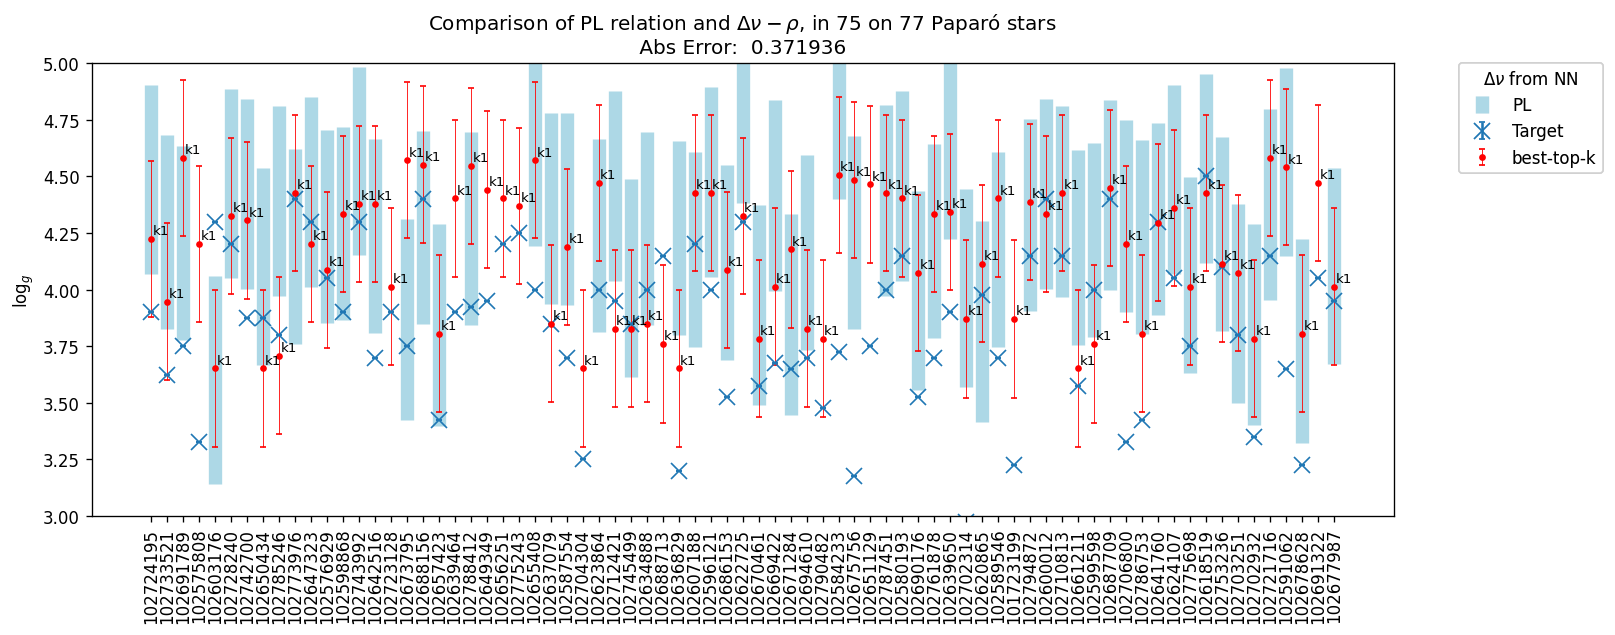

In [37]:
plt.subplots(1, figsize=(14, 5), dpi=120)
plt.errorbar(
    results_corot["id"],
    results_corot["logg-from-P"],
    results_corot["e-logg-from-P"],
    elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=0,
    label="PL",
    color="lightblue",
)
plt.errorbar(
    results_corot["id"],
    results_corot["logg-target"],
    results_corot["e-logg-target"],
    fmt="x",
    markersize=10,
    capsize=2,
    label="Target"
)
plt.errorbar(
    results_corot["id"],
    results_corot["best-top"],
    results_corot["e-best-top"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="red",
    label="best-top-k",
)
for xpos, ypos, name in zip(results_corot["id"], results_corot["best-top"], results_corot["ktop"]):
    plt.annotate(name, (xpos, ypos), xytext=(1, 1), va='bottom', textcoords='offset points', size=8)
plt.xticks(rotation=90)

legend1 = plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0,
    title=r"$\Delta\nu$ from NN",
)
plt.gca().add_artist(legend1)

paparo_abs_error = np.mean(np.abs(results_corot["logg-target"] - results_corot["best-top"]))
plt.ylabel("$\log_g$")
plt.title("Comparison of PL relation and $\Delta\\nu-\\rho$, in %d on 77 Paparó stars \n Abs Error:  %f " % (len(results_corot), paparo_abs_error))
np.mean(np.abs(results_corot["logg-target"] - results_corot["best-top"]))
plt.ylim(3, 5)
plt.show()